XGBoost Model for the 3year data (includes 3 years of finance data and 3 years of news data) with **walkfoward testing**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Combined_3year_data.csv to Combined_3year_data.csv


In [3]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from math import sqrt
import numpy as np

#load and prep data
df = pd.read_csv("Combined_3year_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by=["ticker", "date"])
df = df.dropna()

#define features and target
features = [
    "average_sentiment", "comment_volume", "RealizedVol_3d"
]
target = "Target"

#store RMSEs and predictions
rmse_list = []
predictions = []

#loop over each ticker separately
for ticker in df["ticker"].unique():
    ticker_df = df[df["ticker"] == ticker].copy().reset_index(drop=True)

    min_train_size = 100  # minimum days before we start testing
    if len(ticker_df) <= min_train_size:
        continue

    for i in range(min_train_size, len(ticker_df) - 1):
        train = ticker_df.iloc[:i]
        test = ticker_df.iloc[i:i+1]

        X_train = train[features]
        y_train = train[target]
        X_test = test[features]
        y_test = test[target]

        #model pipeline
        model = make_pipeline(
            StandardScaler(),
            XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        rmse = sqrt(mean_squared_error(y_test, y_pred))
        rmse_list.append(rmse)
        predictions.append({
            "date": test["date"].values[0],
            "ticker": ticker,
            "true": y_test.values[0],
            "predicted": y_pred[0]
        })

#results
avg_rmse = np.mean(rmse_list)
print("Average RMSE across all steps:", np.mean(rmse_list))

# convert predictions to DataFrame for plotting
pred_df = pd.DataFrame(predictions)

Average RMSE across all steps: 0.006858046364172862


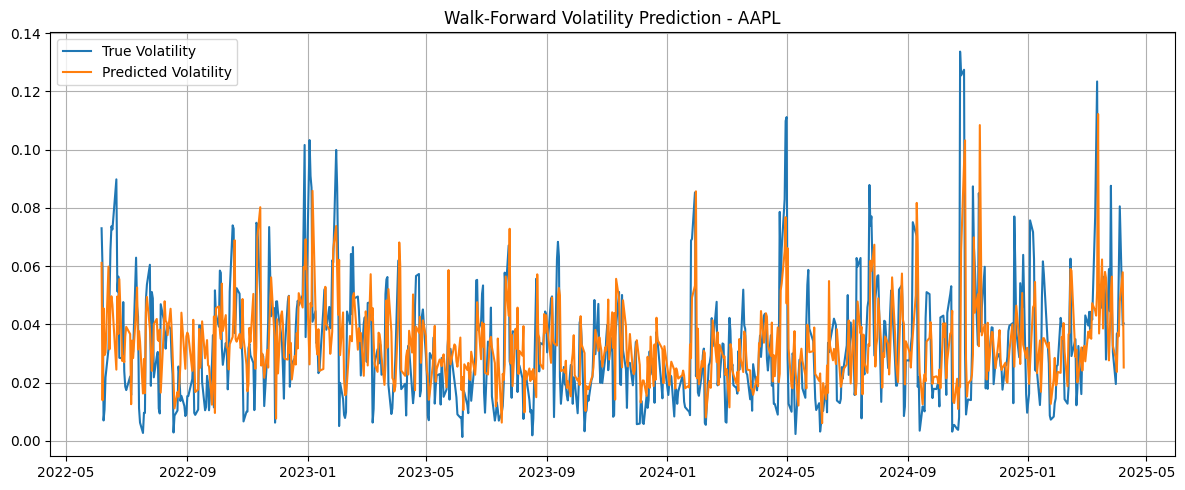

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot prediction vs actual for a ticker
sample = pred_df[pred_df["ticker"] == "TSLA"]

plt.figure(figsize=(12, 5))
plt.plot(sample["date"], sample["true"], label="True Volatility")
plt.plot(sample["date"], sample["predicted"], label="Predicted Volatility")
plt.title("Walk-Forward Volatility Prediction - AAPL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
# compare to the GARCH model
from google.colab import files
uploaded = files.upload()

Saving garch_volatility_predictions.csv to garch_volatility_predictions.csv


In [7]:
import pandas as pd
garch_df = pd.read_csv("garch_volatility_predictions.csv")

#prepare GARCH prediction
garch_df["date"] = pd.to_datetime(garch_df["date"])
garch_df = garch_df.rename(columns={"Rolling_GARCH_volatility %": "garch_predicted"})
garch_df["garch_predicted"] = garch_df["garch_predicted"].astype(float)

# merge and compare
merged = pd.merge(pred_df, garch_df, on=["ticker", "date"])
merged["garch_predicted"] = merged["garch_predicted"].astype(float) / 100
garch_rmse = sqrt(mean_squared_error(merged["true"], merged["garch_predicted"]))

print(f"XGBoost RMSE: {avg_rmse:.4f}")
print(f"GARCH RMSE: {garch_rmse:.4f}")

XGBoost RMSE: 0.0069
GARCH RMSE: 0.0115


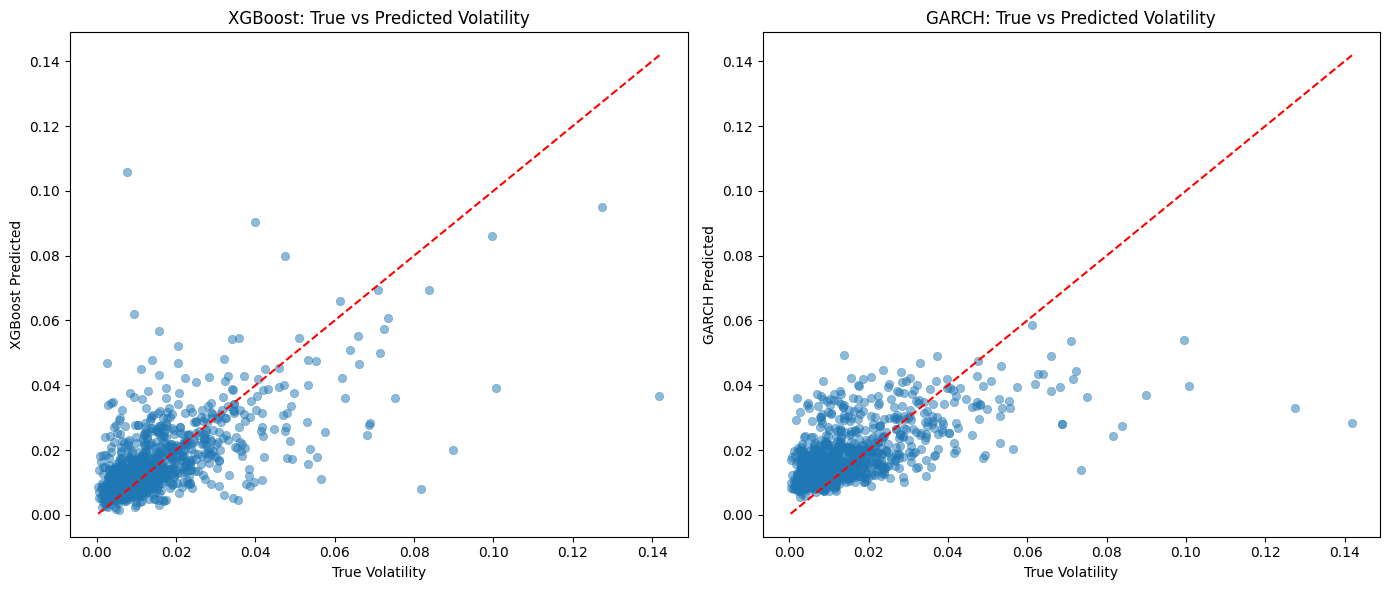

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

#subsample for performance
sampled = merged.sample(n=1000, random_state=42) if len(merged) > 1000 else merged.copy()

#true vs predicted Scatter Plot
plt.figure(figsize=(14, 6))

# XGBoost subplot
plt.subplot(1, 2, 1)
sns.scatterplot(data=sampled, x="true", y="predicted", alpha=0.5, edgecolor=None)
plt.plot([sampled["true"].min(), sampled["true"].max()],
         [sampled["true"].min(), sampled["true"].max()],
         color="red", linestyle="--")
plt.title("XGBoost: True vs Predicted Volatility")
plt.xlabel("True Volatility")
plt.ylabel("XGBoost Predicted")

# GARCH subplot
plt.subplot(1, 2, 2)
sns.scatterplot(data=sampled, x="true", y="garch_predicted", alpha=0.5, edgecolor=None)
plt.plot([sampled["true"].min(), sampled["true"].max()],
         [sampled["true"].min(), sampled["true"].max()],
         color="red", linestyle="--")
plt.title("GARCH: True vs Predicted Volatility")
plt.xlabel("True Volatility")
plt.ylabel("GARCH Predicted")

plt.tight_layout()
plt.show()


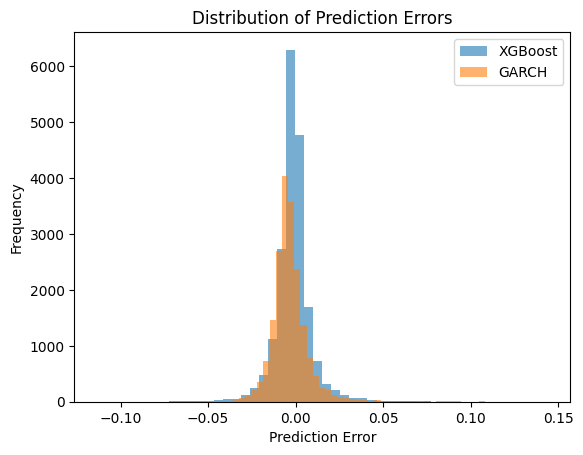

In [ ]:
#Error Analysis
#add residuals
merged["xgb_error"] = merged["true"] - merged["predicted"]
merged["garch_error"] = merged["true"] - merged["garch_predicted"]

#histogram of residuals
import matplotlib.pyplot as plt
plt.hist(merged["xgb_error"], bins=50, alpha=0.6, label="XGBoost")
plt.hist(merged["garch_error"], bins=50, alpha=0.6, label="GARCH")
plt.title("Distribution of Prediction Errors")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()

XGBoost Model for the 3year data (includes 3 years of finance data and 3 years of news data) with **80/20 train/test split**

In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns

#load and prep data
df = pd.read_csv("Combined_3year_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(by=["ticker", "date"])
df = df.dropna()

#define features and target
features3 = [
    "average_sentiment", "comment_volume", "RealizedVol_3d"
]
target3 = "Target"

#80/20 split by date
split_date3 = df["date"].quantile(0.8)
train3 = df[df["date"] <= split_date3]
test3 = df[df["date"] > split_date3]

X_train3 = train3[features3]
y_train3 = train3[target3]
X_test3 = test3[features3]
y_test3 = test3[target3]

#train model
model3 = make_pipeline(
    StandardScaler(),
    XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
)
model3.fit(X_train3, y_train3)

#predict and evaluate
test3 = test3.copy()
test3["predicted_target"] = model3.predict(X_test3)
rmse3 = sqrt(mean_squared_error(y_test3, test3["predicted_target"]))
print("Time-aware test RMSE:", rmse3)

Time-aware test RMSE: 0.01032608562337537


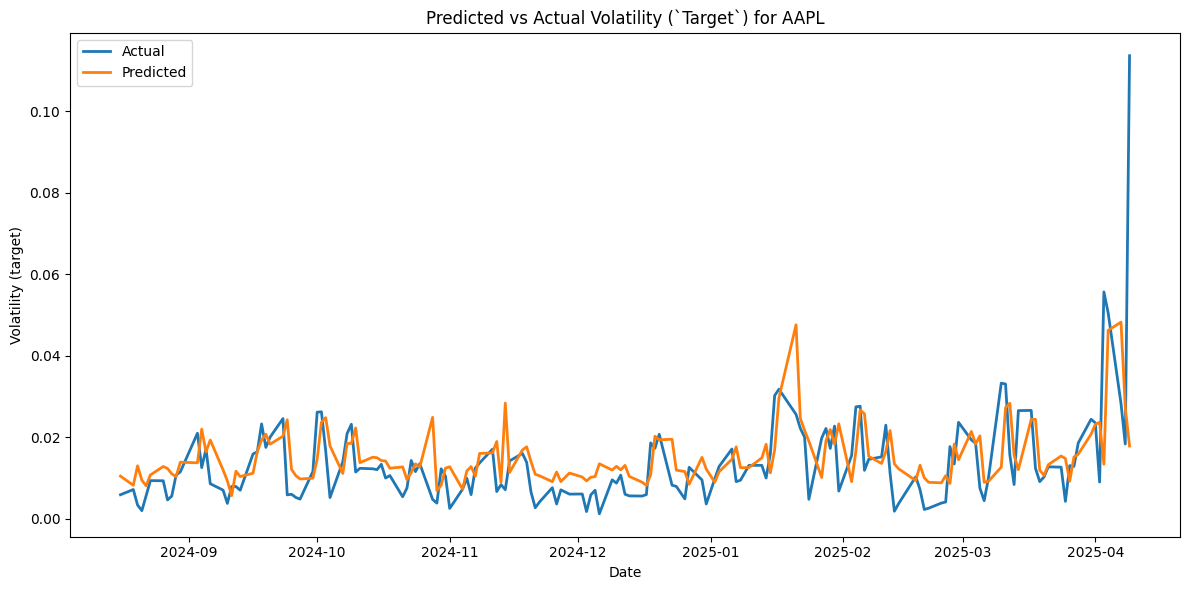

In [ ]:
#pick a ticker to visualize
ticker = "AAPL"
df_plot3 = test3[test3["ticker"] == ticker].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot3, x="date", y="Target", label="Actual", linewidth=2)
sns.lineplot(data=df_plot3, x="date", y="predicted_target", label="Predicted", linewidth=2)
plt.title(f"Predicted vs Actual Volatility (`Target`) for {ticker}")
plt.ylabel("Volatility (target)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()

XGBoost Model for the 1year data (includes 1 year of finance data, 1 years of news data, 1 year of reddit data) with **walkfoward testing**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving FINAL_1YEAR_DATA.csv to FINAL_1YEAR_DATA.csv


In [ ]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from math import sqrt
import numpy as np

#load and prep data
df1 = pd.read_csv("FINAL_1YEAR_DATA.csv")
df1["date"] = pd.to_datetime(df1["date"])
df1 = df1.sort_values(by=["ticker", "date"])
df1 = df1.dropna()

#define features and target
features1yr = [
    "reddit_sentiment_lag1", "reddit_volume_lag1", "RealizedVol_3d", "news_sentiment_lag1", "news_volume_lag1"
]
target1yr = "Target"

#store RMSEs and predictions
rmse_list1yr = []
predictions1yr = []

#loop over each ticker separately (you could expand to global walk-forward if needed)
for ticker in df["ticker"].unique():
    ticker_df1yr = df1[df1["ticker"] == ticker].copy().reset_index(drop=True)

    min_train_size = 100  # minimum days before we start testing
    if len(ticker_df1yr) <= min_train_size:
        continue

    for i in range(min_train_size, len(ticker_df1yr) - 1):
        train1yr = ticker_df1yr.iloc[:i]
        test1yr = ticker_df1yr.iloc[i:i+1]

        X_train1yr = train1yr[features1yr]
        y_train1yr = train1yr[target1yr]
        X_test1yr = test1yr[features1yr]
        y_test1yr = test1yr[target1yr]

        #model pipeline
        model1yr = make_pipeline(
            StandardScaler(),
            XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
        )
        model1yr.fit(X_train1yr, y_train1yr)
        y_pred1yr = model1yr.predict(X_test1yr)

        rmse1yr = sqrt(mean_squared_error(y_test1yr, y_pred1yr))
        rmse_list1yr.append(rmse1yr)
        predictions1yr.append({
            "date": test1yr["date"].values[0],
            "ticker": ticker,
            "true": y_test1yr.values[0],
            "predicted": y_pred1yr[0]
        })

#results
print("Average RMSE across all steps:", np.mean(rmse_list1yr))

# convert predictions to DataFrame for plotting
pred_df1yr = pd.DataFrame(predictions1yr)

Average RMSE across all steps: 0.007386759028188719


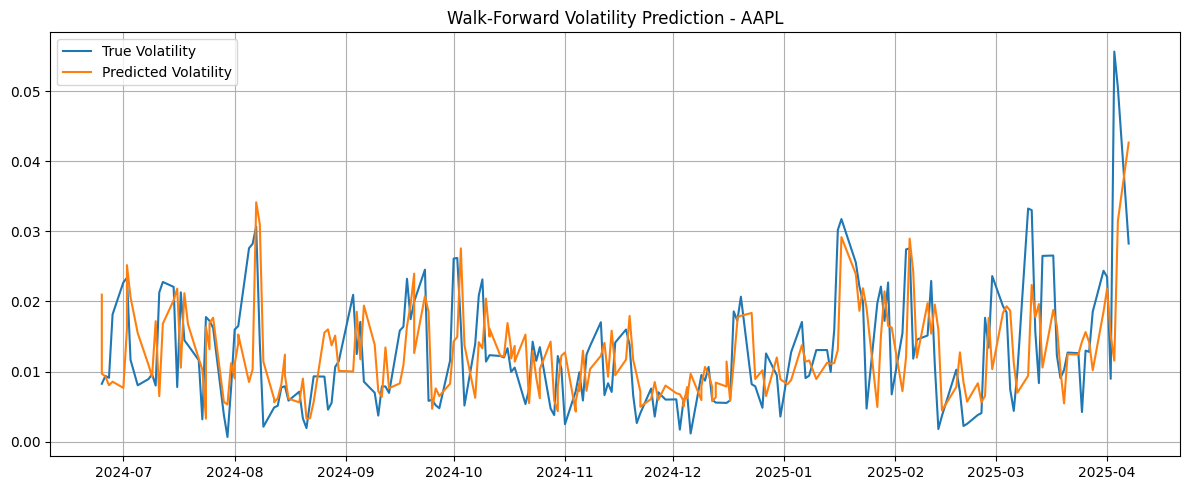

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#plot prediction vs actual for a ticker
sample1 = pred_df1yr[pred_df1yr["ticker"] == "AAPL"]

plt.figure(figsize=(12, 5))
plt.plot(sample1["date"], sample1["true"], label="True Volatility")
plt.plot(sample1["date"], sample1["predicted"], label="Predicted Volatility")
plt.title("Walk-Forward Volatility Prediction - AAPL")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

XGBoost Model for the 1year data (includes 1 year of finance data, 1 years of news data, 1 year of reddit data) with **80/20 train/test split**

In [ ]:
#define features and target
features1 = [
        "reddit_sentiment_lag1", "reddit_volume_lag1", "RealizedVol_3d", "news_sentiment_lag1", "news_volume_lag1"
]
target1 = "Target"

#80/20 split by date
split_date1 = df1["date"].quantile(0.8)
train1 = df1[df1["date"] <= split_date1]
test1 = df1[df1["date"] > split_date1]

X_train1 = train1[features1]
y_train1 = train1[target1]
X_test1 = test1[features1]
y_test1 = test1[target1]

#train model
model1 = make_pipeline(
    StandardScaler(),
    XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.05, random_state=42)
)
model1.fit(X_train1, y_train1)

#predict and evaluate
test1 = test1.copy()
test1["predicted_target"] = model1.predict(X_test1)
rmse1 = sqrt(mean_squared_error(y_test1, test1["predicted_target"]))
print("Time-aware test RMSE:", rmse1)

Time-aware test RMSE: 0.011809037503737782


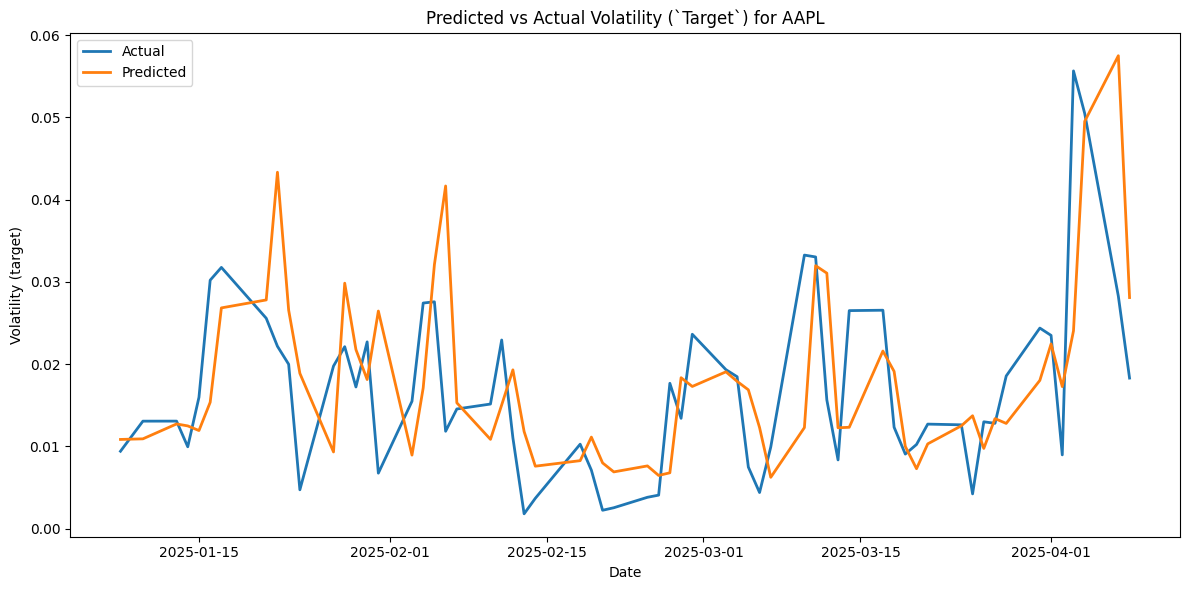

In [ ]:
#pick a ticker to visualize
ticker = "AAPL"
df_plot1 = test1[test1["ticker"] == ticker].copy()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_plot1, x="date", y="Target", label="Actual", linewidth=2)
sns.lineplot(data=df_plot1, x="date", y="predicted_target", label="Predicted", linewidth=2)
plt.title(f"Predicted vs Actual Volatility (`Target`) for {ticker}")
plt.ylabel("Volatility (target)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()